In [2]:
import os
# os.chdir('../')
os.getcwd()

'/home/siddhartha/clusterFL'

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from models.loader import load_model
from client import Client
from datasets.dataloader import load_global_dataset, create_clustered_dataset
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

In [4]:
train, test = load_global_dataset('cifar10')
datasets = create_clustered_dataset(train, 2, 'rotation')
dataset1_train, dataset2_train = datasets

val_size = len(dataset1_train) // 10
train_size = len(dataset1_train) - val_size
train_dataset1, val_dataset1 = torch.utils.data.random_split(dataset1_train, [train_size, val_size])
train_dataset2, val_dataset2 = torch.utils.data.random_split(dataset2_train, [train_size, val_size])

dataset2_sub1_train = Subset(train_dataset2, range(len(train_dataset2)//2))
dataset2_sub1_val = Subset(val_dataset2, range(len(val_dataset2)//2))
dataset2_sub2_train = Subset(train_dataset2, range(len(train_dataset2)//2, len(train_dataset2)))
dataset2_sub2_val = Subset(val_dataset2, range(len(val_dataset2)//2, len(val_dataset2)))

client1_train_loader = DataLoader(train_dataset1, batch_size=32, shuffle=True)
client1_val_loader = DataLoader(val_dataset1, batch_size=32, shuffle=False)
client2_train_loader = DataLoader(dataset2_sub1_train, batch_size=32, shuffle=True) 
client2_val_loader = DataLoader(dataset2_sub1_val, batch_size=32, shuffle=False)
client3_train_loader = DataLoader(dataset2_sub2_train, batch_size=32, shuffle=True)
client3_val_loader = DataLoader(dataset2_sub2_val, batch_size=32, shuffle=False)

print('Client 1:', len(client1_train_loader), len(client1_val_loader))
print('Client 2:', len(client2_train_loader), len(client2_val_loader))
print('Client 3:', len(client3_train_loader), len(client3_val_loader))

Files already downloaded and verified
Files already downloaded and verified
Client 1: 1407 157
Client 2: 704 79
Client 3: 704 79


In [5]:
def permute_linear_neurons(seq, layer_indices):
    
    permuted_seq = deepcopy(seq)
    layer1 = permuted_seq[layer_indices[0]]
    layer2 = permuted_seq[layer_indices[1]]

    # reorder the hidden neurons from layer1 to layer2
    layer1_weight = layer1.weight
    layer1_bias = layer1.bias
    layer2_weight = layer2.weight
    layer2_bias = layer2.bias

    perm =  torch.randperm(layer1_weight.size(0))
    layer1_weight = layer1_weight[perm]
    layer2_weight = layer2_weight[:,perm]

    permuted_seq[layer_indices[0]].weight.data = layer1_weight
    permuted_seq[layer_indices[0]].bias.data = layer1_bias
    permuted_seq[layer_indices[1]].weight.data = layer2_weight
    permuted_seq[layer_indices[1]].bias.data = layer2_bias

    return permuted_seq



In [11]:
model = load_model('cifarcnn').to('cuda')

In [12]:
client = Client(id=0, device=torch.device('cuda:0'), cluster_assignment=0)
# train the model on the client
criterion = nn.CrossEntropyLoss()
model1 = deepcopy(model)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
model1 = client.train(model1, client1_train_loader, criterion, optimizer1, num_epochs=2)
model2 = deepcopy(model)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
model2 = client.train(model2, client2_train_loader, criterion, optimizer2, num_epochs=2)
model3 = deepcopy(model)
optimizer3 = torch.optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
model3 = client.train(model3, client3_train_loader, criterion, optimizer3, num_epochs=2)



Client 0 initialized on device:  cuda:0
Client 0 epoch 0 loss: 1.5287156983648706
Client 0 epoch 1 loss: 1.2018755307922824
Client 0 epoch 0 loss: 1.6577644490382888
Client 0 epoch 1 loss: 1.3403813164173202
Client 0 epoch 0 loss: 1.6808918364854022
Client 0 epoch 1 loss: 1.3663071456619285


In [16]:
client1_conv1 = model1.nn[0].weight.data.cpu()
client2_conv1 = model2.nn[0].weight.data.cpu()
client3_conv1 = model3.nn[0].weight.data.cpu()

client1_conv1.shape

torch.Size([16, 3, 5, 5])

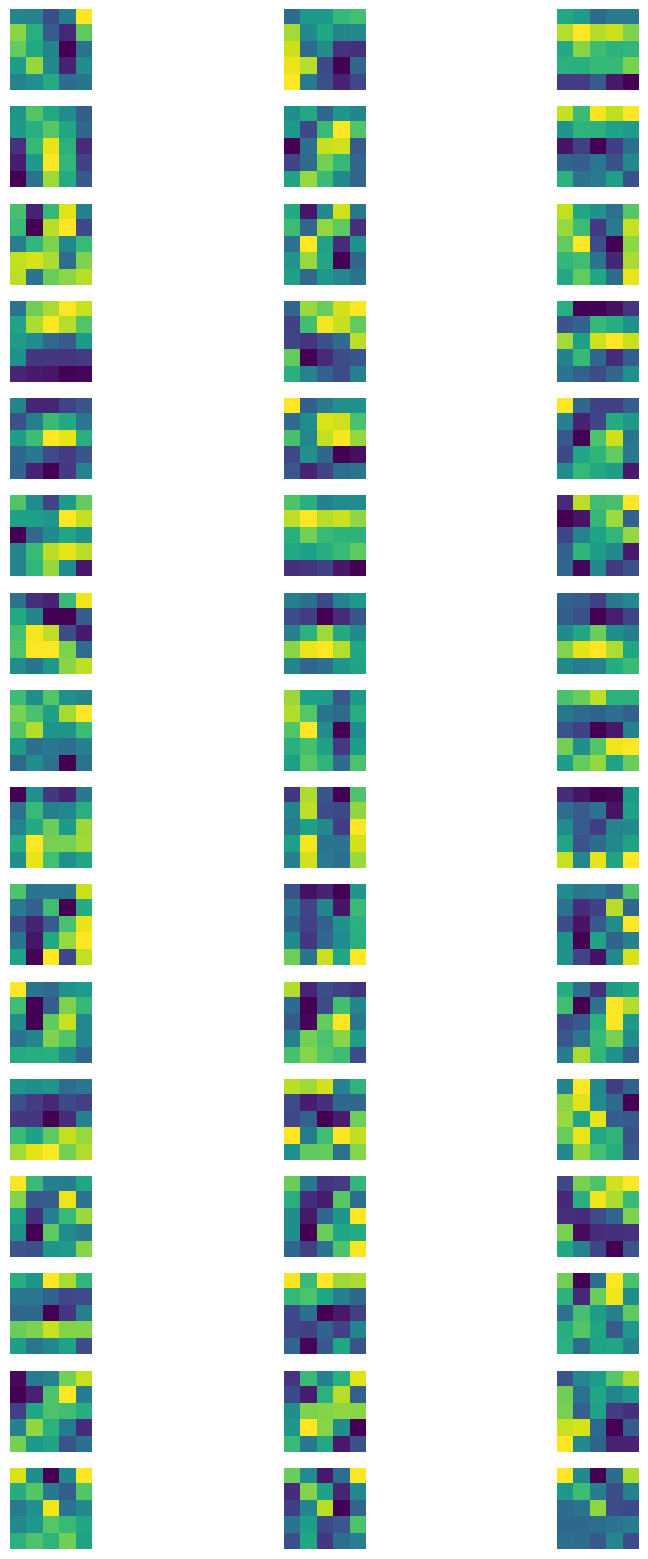

In [37]:
# for each client, populate a set with the conv filters
client1_filters = list([cfilter for cfilter in client1_conv1])
client2_filters = list([cfilter for cfilter in client2_conv1])
client3_filters = list([cfilter for cfilter in client3_conv1])
np.random.shuffle(client3_filters)
# plot filters
fig, axs = plt.subplots(len(client2_filters), 3, figsize=(10, 20))
for i, (filter1, filter2, filter3) in enumerate(zip(client1_filters, client2_filters, client3_filters)):
    axs[i, 0].imshow(filter1[0].detach().numpy())
    axs[i, 1].imshow(filter2[0].detach().numpy())
    axs[i, 2].imshow(filter3[0].detach().numpy())
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')
plt.show()



In [38]:
def filter_dist(filter1, filter2):
    return torch.dist(filter1, filter2,p=1)
def compute_filter_dist(client1_filters, client2_filters):
    dist_mat = np.zeros((len(client1_filters), len(client2_filters)))
    for i, filter1 in enumerate(client1_filters):
        for j, filter2 in enumerate(client2_filters):
            dist_mat[i, j] = filter_dist(filter1, filter2)
    return dist_mat
def match_filters(dist_mat_full):
    # match filters. once two filters are matched, remove them from the list
    matches = []
    dist_mat = dist_mat_full.copy()
    rows, cols = dist_mat.shape
    for _ in range(dist_mat.shape[0]):
        i, j = np.unravel_index(np.argmin(dist_mat, axis=None), dist_mat.shape)
        dist = dist_mat[i, j]
        matches.append((i, j, dist))
        dist_mat[i, :] = np.inf
        dist_mat[:, j] = np.inf
    return matches

dist_mat_12 = compute_filter_dist(client1_filters, client2_filters)
matches_12 = match_filters(dist_mat_12) 
dist_mat_13 = compute_filter_dist(client1_filters, client3_filters)
matches_13 = match_filters(dist_mat_13)
dist_mat_23 = compute_filter_dist(client2_filters, client3_filters) 
matches_23 = match_filters(dist_mat_23)

print("matches 12 max matched dist:", max([match[2] for match in matches_12]))
print("matches 13 max matched dist:", max([match[2] for match in matches_13]))
print("matches 23 max matched dist:", max([match[2] for match in matches_23]))

matches 12 max matched dist: 14.16061782836914
matches 13 max matched dist: 11.960638999938965
matches 23 max matched dist: 9.799064636230469


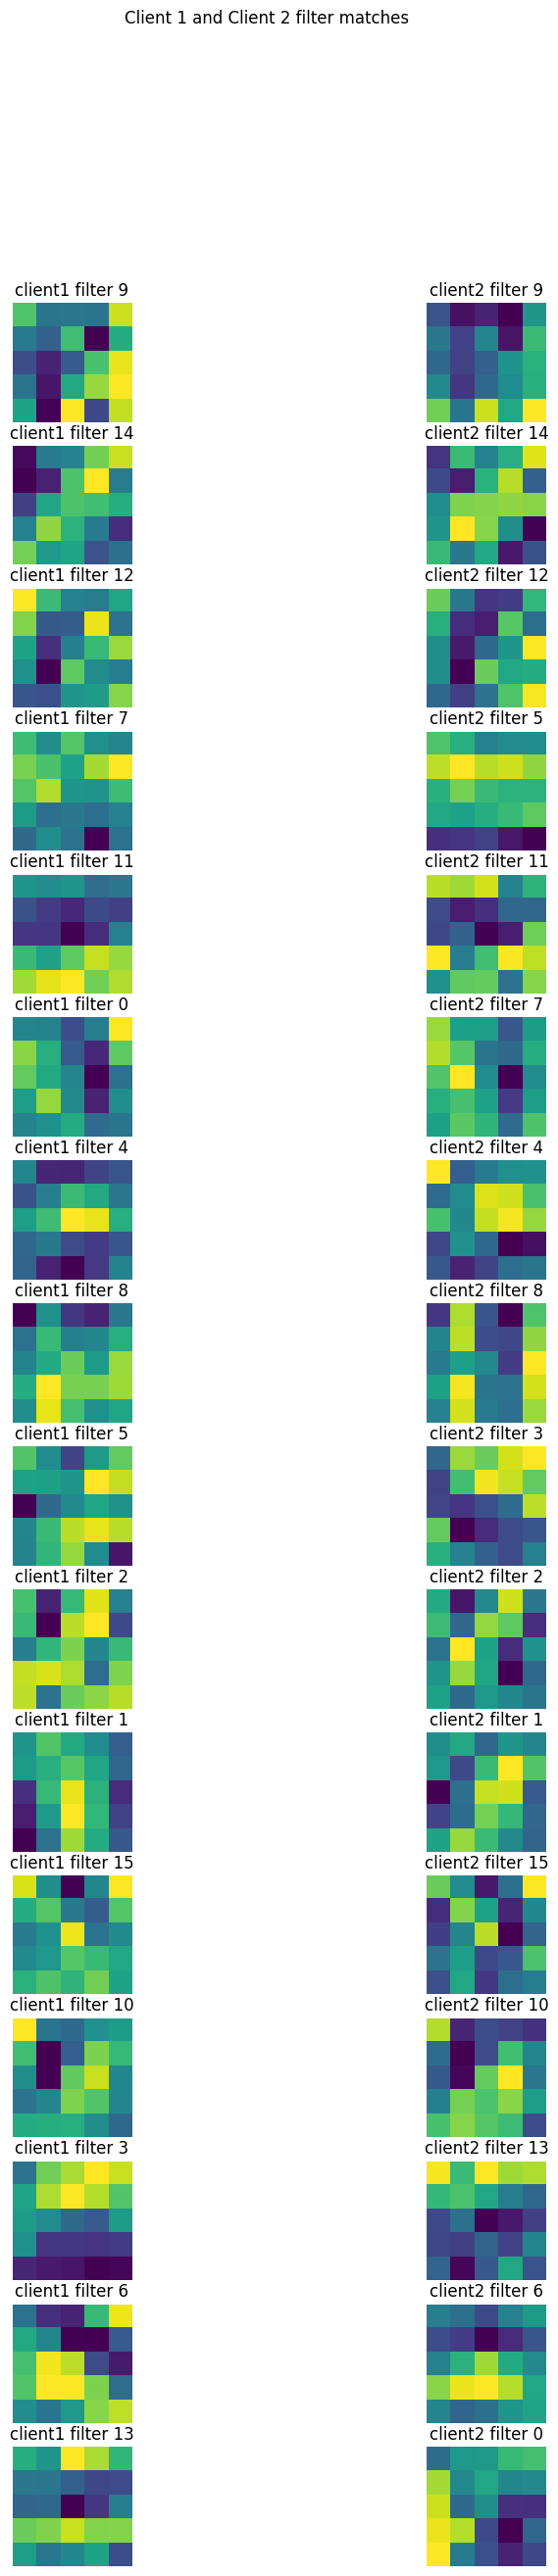

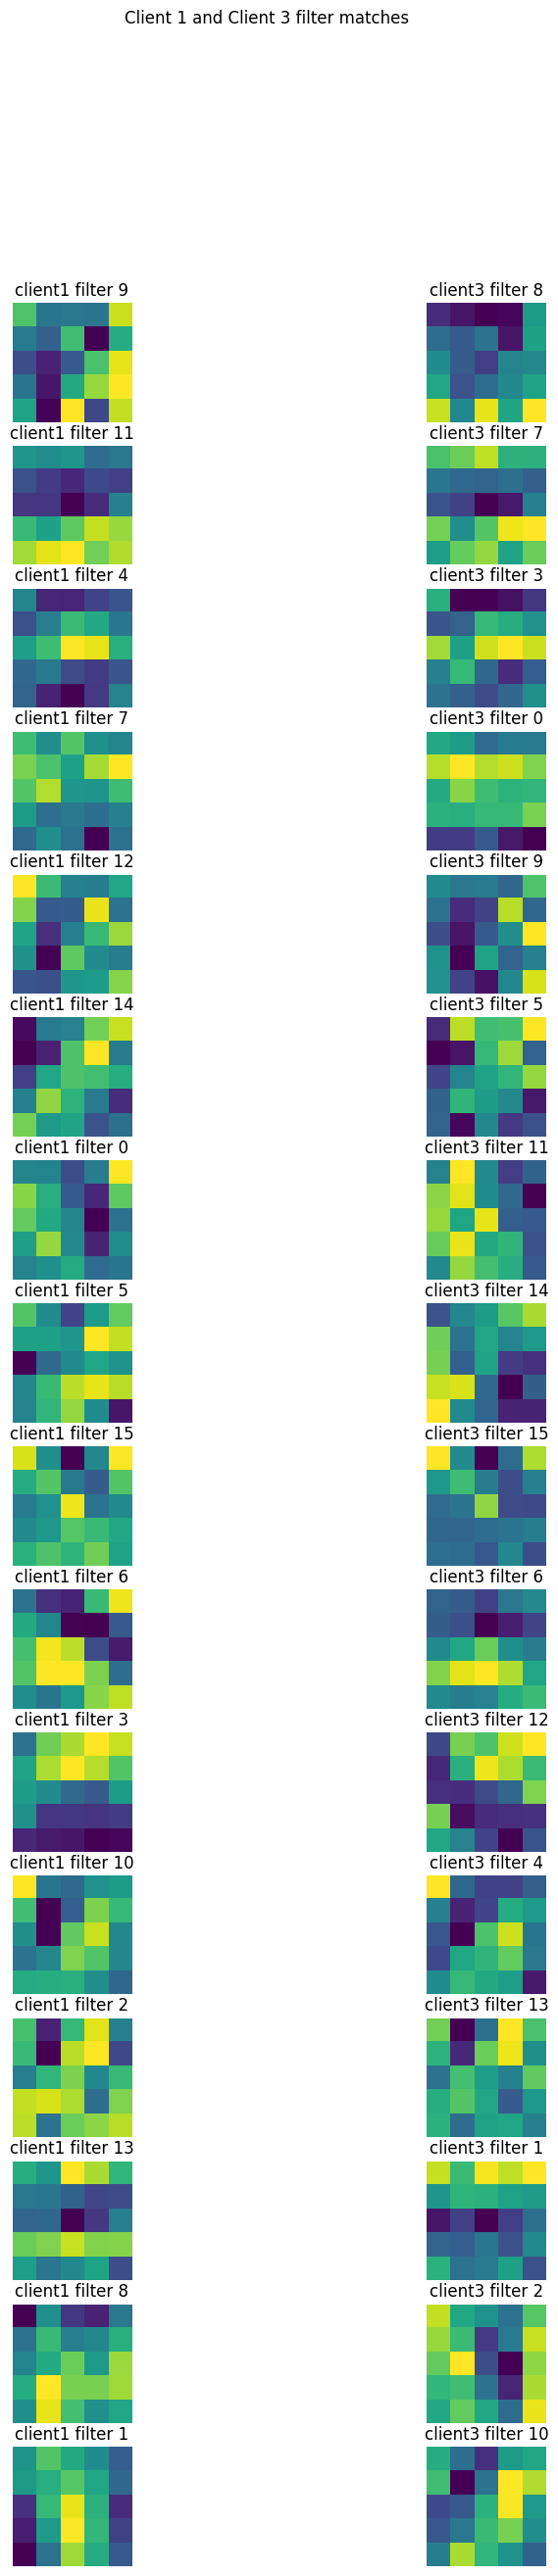

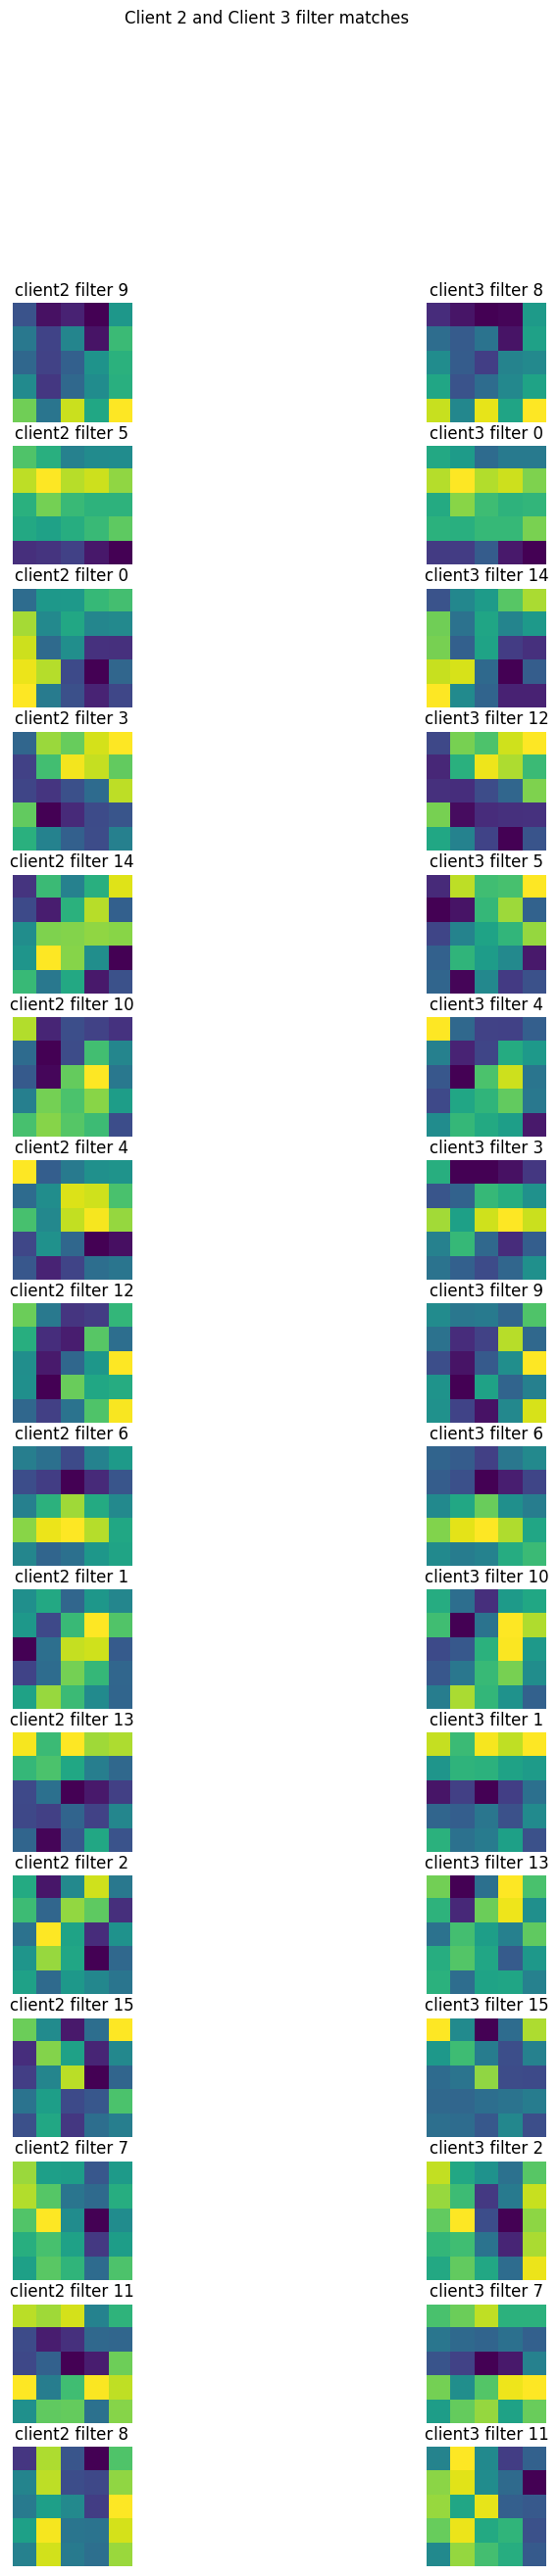

In [42]:
# plot the filter matches
fig, axs = plt.subplots(len(matches_12), 2, figsize=(10, 30))
for i, (match12, match23) in enumerate(zip(matches_12, matches_23)):
    filter1, filter2, dist = match12
    axs[i, 0].imshow(client1_filters[filter1][0].detach().numpy())
    axs[i,0].set_title(f'client1 filter {filter1}')
    axs[i, 1].imshow(client2_filters[filter2][0].detach().numpy())
    axs[i,1].set_title(f'client2 filter {filter2}')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
fig.suptitle('Client 1 and Client 2 filter matches')    
plt.show()

fig, axs = plt.subplots(len(matches_13), 2, figsize=(10, 30))
for i, (match13, match23) in enumerate(zip(matches_13, matches_23)):
    filter1, filter2, dist = match13
    axs[i, 0].imshow(client1_filters[filter1][0].detach().numpy())
    axs[i,0].set_title(f'client1 filter {filter1}')
    axs[i, 1].imshow(client3_filters[filter2][0].detach().numpy())
    axs[i,1].set_title(f'client3 filter {filter2}')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
fig.suptitle('Client 1 and Client 3 filter matches')
plt.show()

fig, axs = plt.subplots(len(matches_23), 2, figsize=(10, 30))
for i, (match23, match23) in enumerate(zip(matches_23, matches_23)):
    filter1, filter2, dist = match23
    axs[i, 0].imshow(client2_filters[filter1][0].detach().numpy())
    axs[i,0].set_title(f'client2 filter {filter1}')
    axs[i, 1].imshow(client3_filters[filter2][0].detach().numpy())
    axs[i,1].set_title(f'client3 filter {filter2}')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
fig.suptitle('Client 2 and Client 3 filter matches')
plt.show()
